In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.stats.multitest as multi

from CosinorPy import file_parser, cosinor, cosinor1
from CosinorPy.helpers import df_add_row
from RhythmCount import data_processing as dproc
from RhythmCount import plot

In [2]:
data = pd.read_csv("../PrometneNesreče.csv")

C:\Users\Hana\AppData\Local\Temp\ipykernel_7300\3596567331.py:1: DtypeWarning: Columns (31,32,33,34,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../PrometneNesreče.csv")


# Kosinor analiza po urah: delovnik vs. vikend

In [3]:
# Pretvori stolpec 'NastanekDatumCas' v pravilen format (vsaka vrednost bo pandas objekt za datum in čas)
data['NastanekDatumCas'] = pd.to_datetime(data['NastanekDatumCas'], format='ISO8601', errors='coerce')

# Dodaj stolpca za uro in dan v tednu
data['hour'] = data['NastanekDatumCas'].dt.hour
data['weekday'] = data['NastanekDatumCas'].dt.weekday

# Razdeli dneve na delovnik in vikend
workdays = data[data['weekday'] < 5]
weekends = data[data['weekday'] >= 5]

# Preštej nesreče po urah za delovnik
accidents_per_hour_workdays = workdays['hour'].value_counts().sort_index()

# Preštej nesreče po urah za vikend
accidents_per_hour_weekend = weekends['hour'].value_counts().sort_index()

# Ustvari pandas dataframe v formatu, ki bo primeren za uporabo CosinorPy
df_workdays = pd.DataFrame({
    "test": "HourlyAccidents_Workdays",  # konstantna oznaka vseh vrstic
    "x": accidents_per_hour_workdays.index,  # Ura (od 0 do 23)
    "y": accidents_per_hour_workdays.values  # Število nesreč za tisto uro
})

df_weekends = pd.DataFrame({
    "test": "HourlyAccidents_Weekends",  # konstantna oznaka vseh vrstic
    "x": accidents_per_hour_weekend.index,  # Ura (od 0 do 23)
    "y": accidents_per_hour_weekend.values  # Število nesreč za tisto uro
})


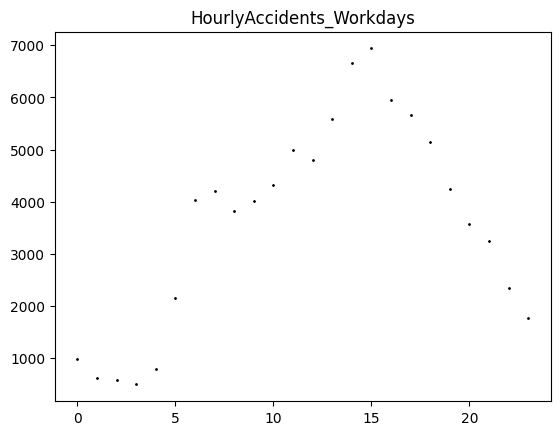

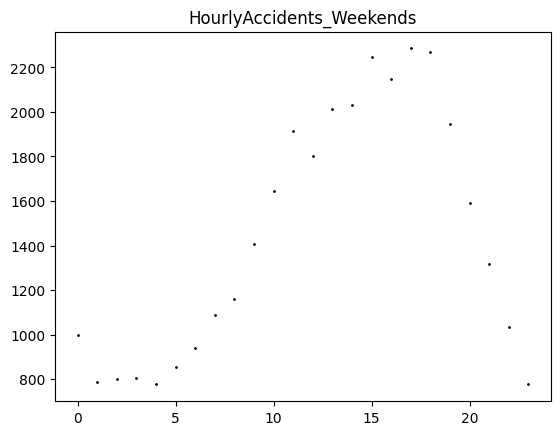

In [4]:
cosinor.plot_data(df_workdays, names = ["HourlyAccidents_Workdays"])
cosinor.plot_data(df_weekends, names = ["HourlyAccidents_Weekends"])

## Periodogram

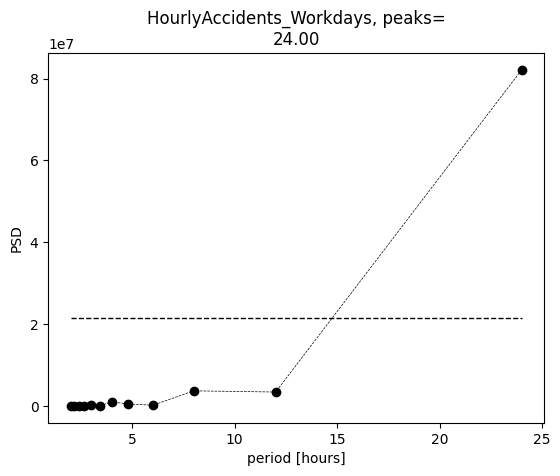

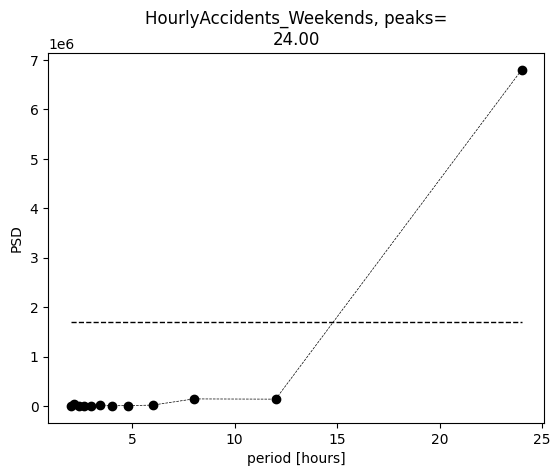

In [5]:
cosinor.periodogram_df(df_workdays)
cosinor.periodogram_df(df_weekends)

## CosinorPy

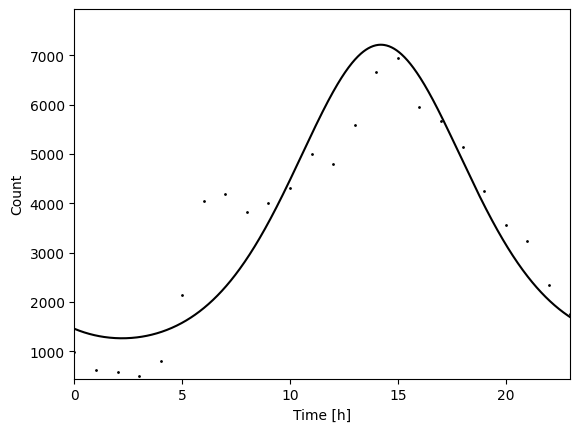

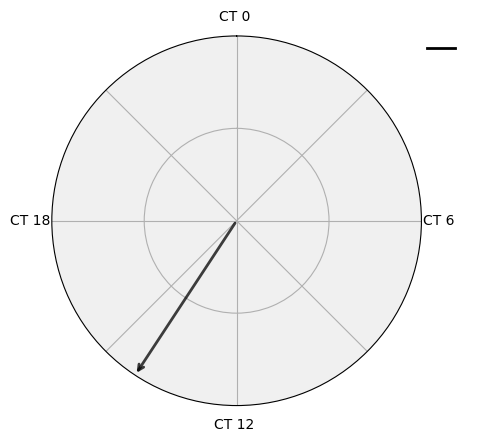

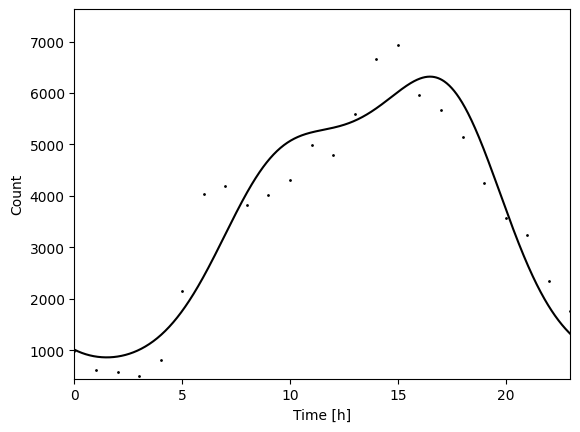

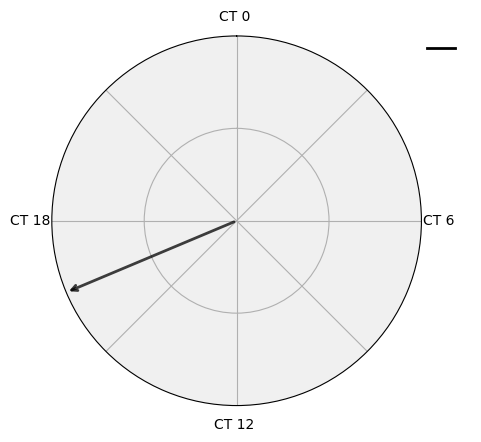

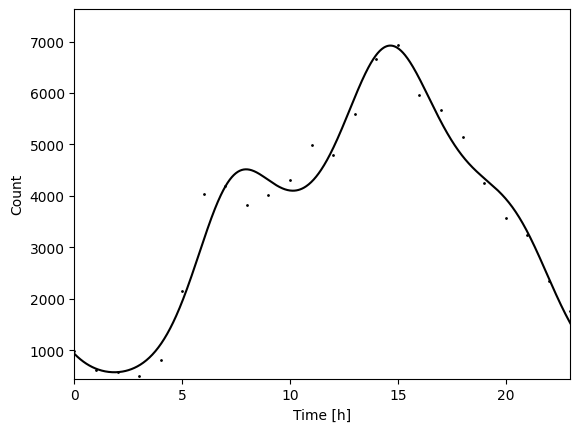

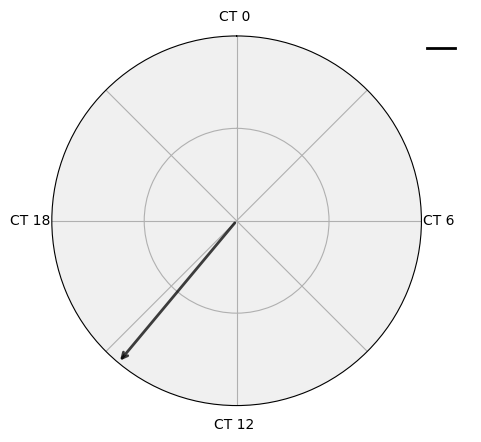

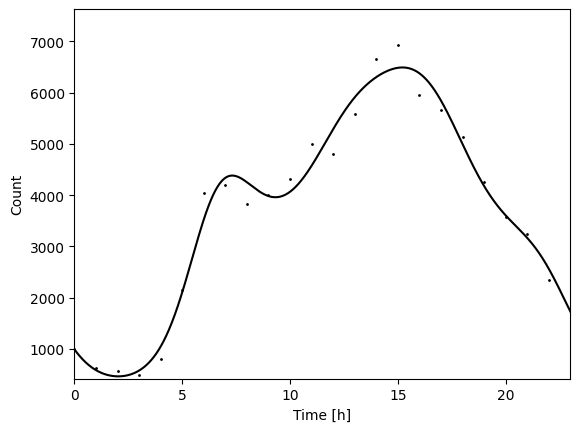

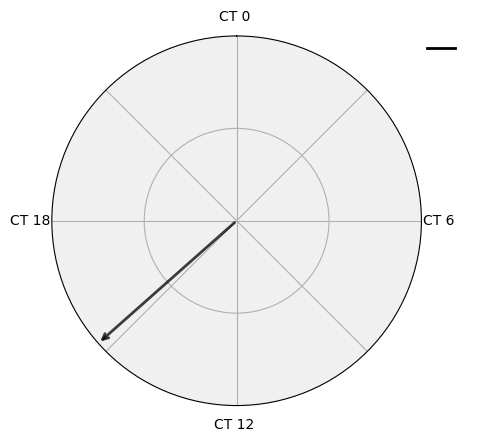

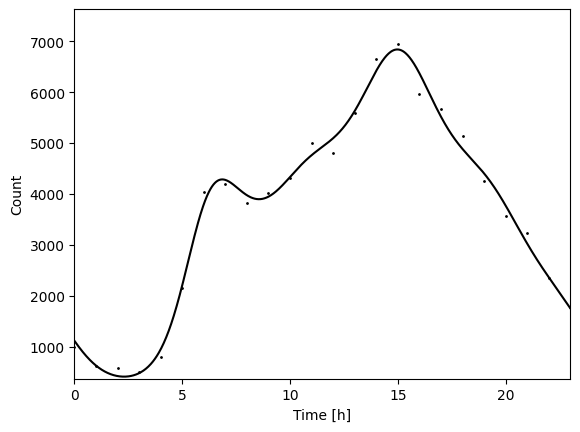

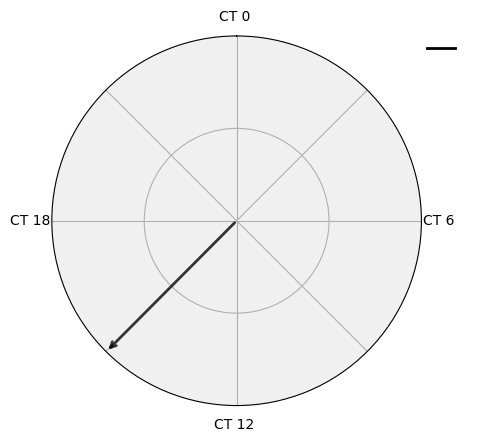

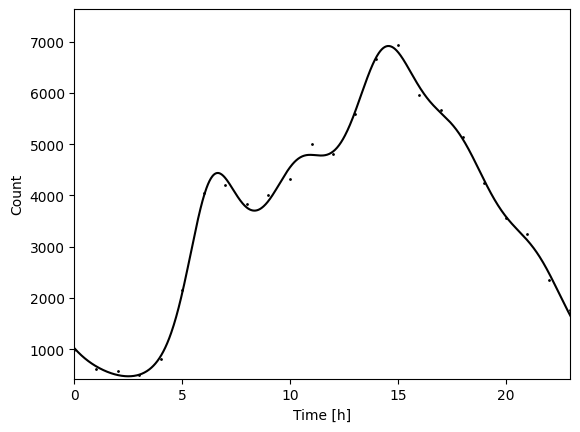

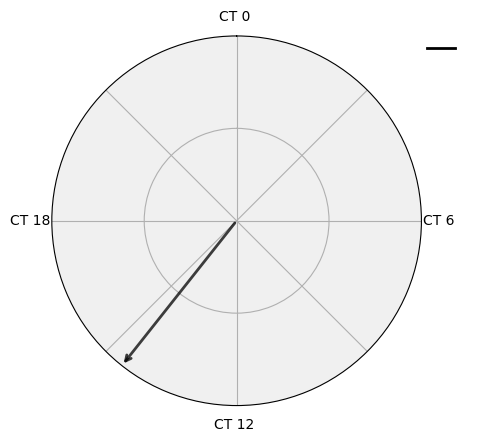

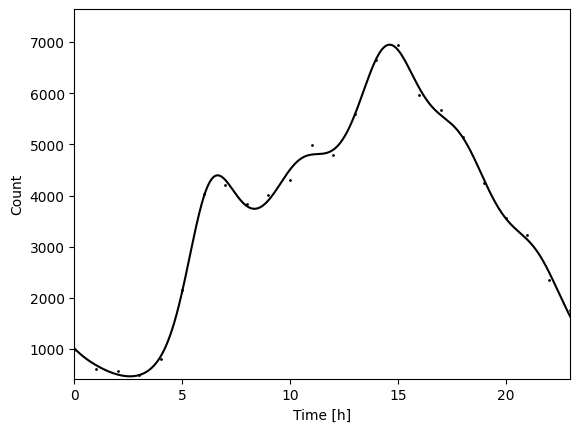

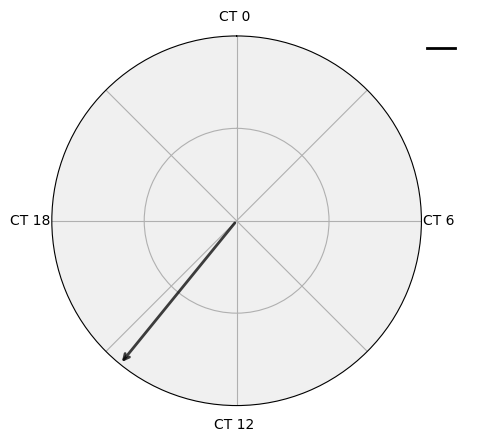

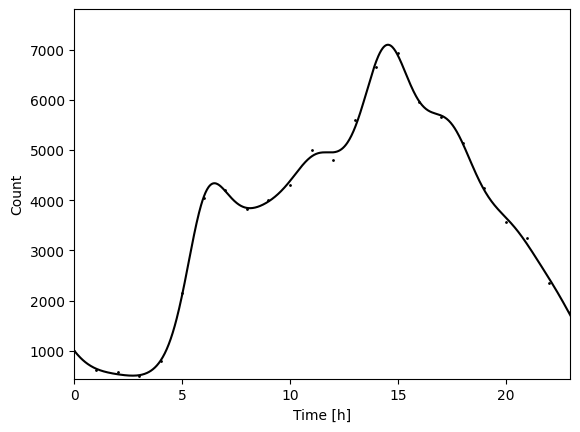

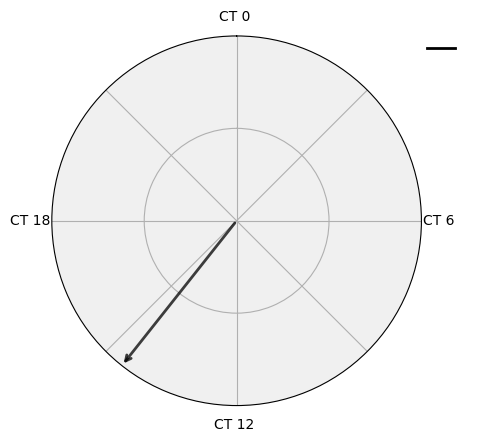

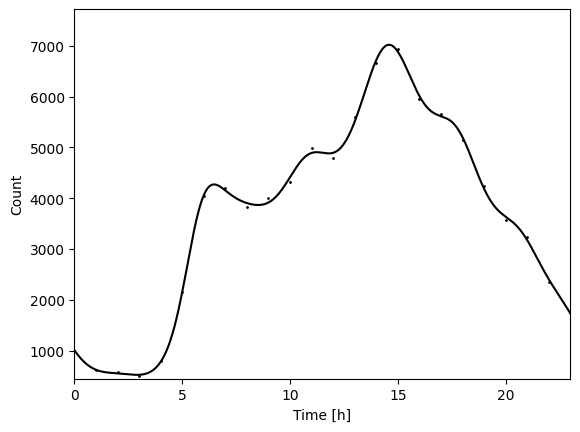

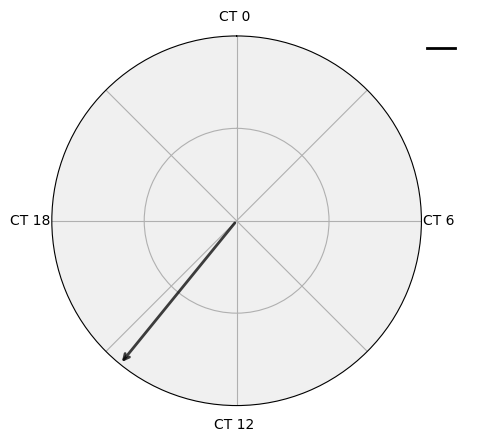

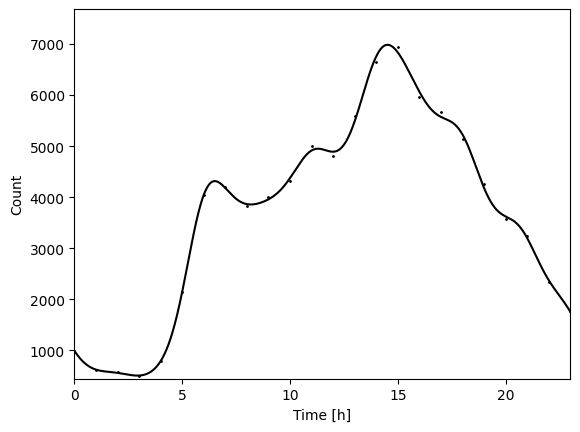

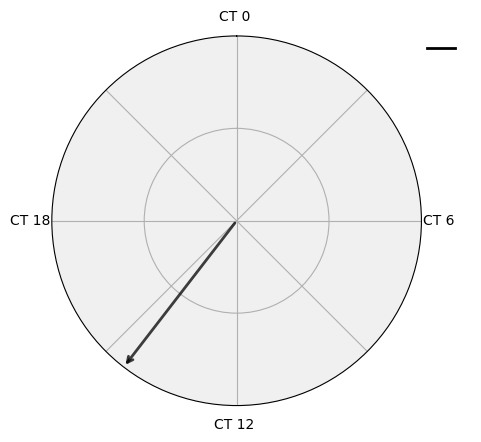

In [6]:
# DELOVNIK
X = df_workdays.x.to_numpy()
Y = df_workdays.y.to_numpy()

df_results_work = pd.DataFrame(columns=[
    'test', 'period', 'n_components', 'p', 'q', 'RSS', 
    'log-likelihood', 'prsquared', 'amplitude', 'acrophase', 
    'mesor', 'peaks', 'heights', 'troughs', 'heights2'
], dtype=float)

numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for i in numbers:
    results, statistics, rhythm_param, _, _ = cosinor.fit_me(X, Y, n_components = i, period = 24, model_type = 'gen_poisson', plot_margins=False)
    #result_table.append(result)

    # print("Statistics:", statistics.keys())
    # print("Rhythm parameters:", rhythm_param.keys())
    # print("Results attributes:", dir(results))

    df_results_work = df_add_row(df_results_work, {
        'test': 'HourlyAccidents_Workdays', 
        'period': 24,
        'n_components': i,
        'p': statistics['p'], 
        'RSS': statistics['RSS'],
        'log-likelihood': results.llf,        
        'prsquared': results.prsquared,  # Alternative to R²
        'amplitude': rhythm_param['amplitude'],
        'acrophase': rhythm_param['acrophase'],
        'mesor': rhythm_param['mesor'],
        'peaks': rhythm_param['peaks'],
        'heights': rhythm_param['heights'],
        'troughs': rhythm_param['troughs'],
        'heights2': rhythm_param['heights2']
    })

df_results_work.q = multi.multipletests(df_results_work.p, method = 'fdr_bh')[1]


In [27]:
df_results_work

,test,period,n_components,p,q,RSS,log-likelihood,prsquared,amplitude,acrophase,mesor,peaks,heights,troughs,heights2
0,HourlyAccidents_Workdays,24.0,1.0,3.671951e-11,3.671951e-11,1.751422e+07,-196.366059,0.109022,2974.406171,2.559816,4240.436673,[14.222222222222221],[7214.834722889379],[2.21021021021021],[1266.0305013860616]
1,HourlyAccidents_Workdays,24.0,2.0,1.354438e-13,1.504931e-13,9.567578e+06,-187.232458,0.150464,2728.987957,1.968606,3590.378067,[16.48048048048048],[6319.366023812793],[1.4894894894894894],[861.3901098984097]
2,HourlyAccidents_Workdays,24.0,3.0,1.015179e-18,1.268973e-18,2.743396e+06,-171.849304,0.220262,3175.496135,2.446606,3747.689216,"[7.975975975975976, 14.654654654654655]","[4517.324069590586, 6923.185350152216]",[1.8738738738738738],[572.2270208502526]
3,HourlyAccidents_Workdays,24.0,4.0,1.905914e-20,2.722734e-20,1.739242e+06,-164.662892,0.252870,3015.828064,2.295658,3477.099937,"[7.303303303303303, 15.23123123123123]","[4381.911479104873, 6492.865971079927]",[2.018018018018018],[461.2851187312938]
4,HourlyAccidents_Workdays,24.0,5.0,1.091474e-22,1.819123e-22,7.308042e+05,-156.297574,0.290826,3215.254390,2.358553,3623.896851,"[6.870870870870871, 14.99099099099099]","[4284.925492345506, 6839.038648273662]",[2.3063063063063063],[408.64246069340203]
5,HourlyAccidents_Workdays,24.0,6.0,2.053819e-26,5.134547e-26,2.588315e+05,-144.307393,0.345229,3219.307838,2.471764,3693.928450,"[6.63063063063063, 10.954954954954955, 14.5585...","[4437.729863084388, 4791.154853319141, 6913.23...",[2.4984984984984986],[474.62061130868506]
6,HourlyAccidents_Workdays,24.0,7.0,1.377456e-25,2.754912e-25,2.216029e+05,-143.601844,0.348431,3240.874943,2.459185,3708.903265,"[6.63063063063063, 14.606606606606606]","[4396.508070520453, 6949.778208569109]",[2.5945945945945947],[468.06481320848775]
7,HourlyAccidents_Workdays,24.0,8.0,2.856167e-28,9.520557e-28,1.297371e+05,-134.217647,0.391010,3293.915555,2.471764,3801.509095,"[6.486486486486487, 11.627627627627627, 14.558...","[4338.176015408444, 4953.4888397534505, 7095.0...",[2.6906906906906904],[507.59354035164466]
8,HourlyAccidents_Workdays,24.0,9.0,3.793941e-29,1.896970e-28,9.026850e+04,-129.377648,0.412970,3248.545267,2.459185,3771.193820,"[6.486486486486487, 11.243243243243244, 14.606...","[4270.999200188126, 4905.6648046287, 7019.5568...",[2.8828828828828827],[522.6899546484856]
9,HourlyAccidents_Workdays,24.0,10.0,2.849688e-29,1.896970e-28,9.352513e+04,-126.487648,0.426083,3237.995164,2.484343,3745.864743,"[6.534534534534535, 11.29129129129129, 14.5105...","[4314.980600020561, 4949.649253450087, 6983.85...",[2.930930930930931],[507.869578901991]


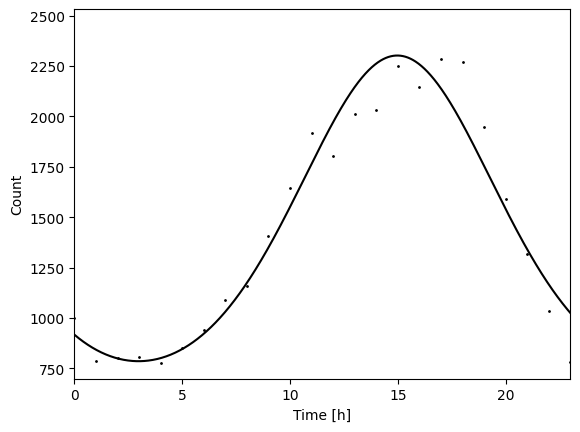

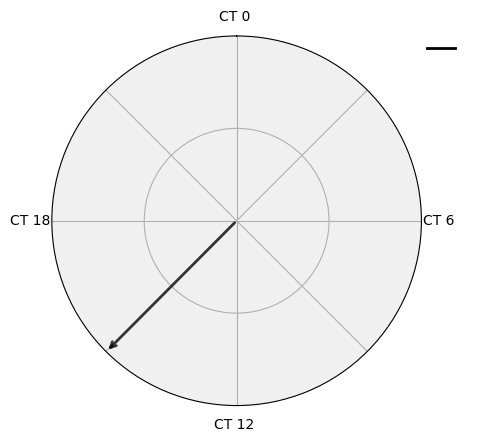

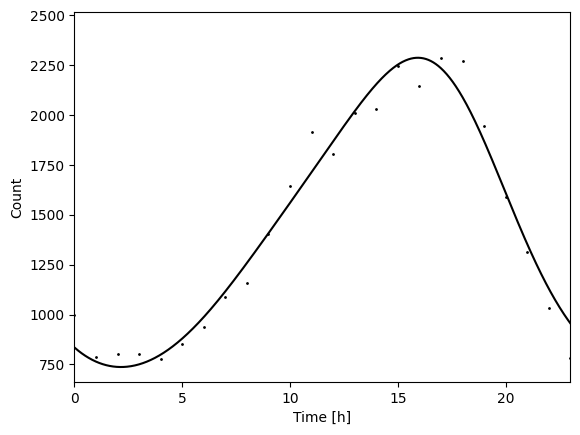

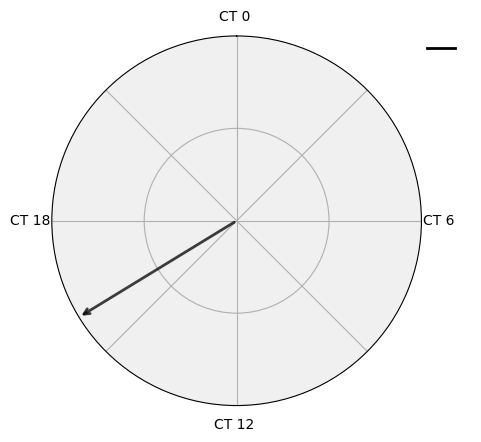

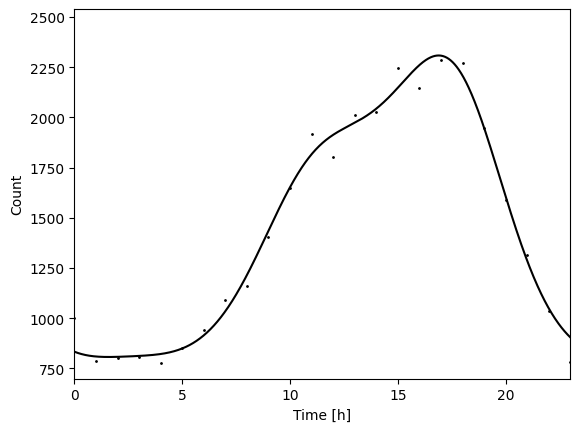

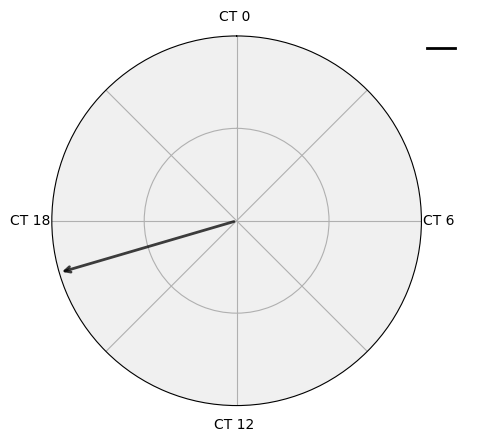

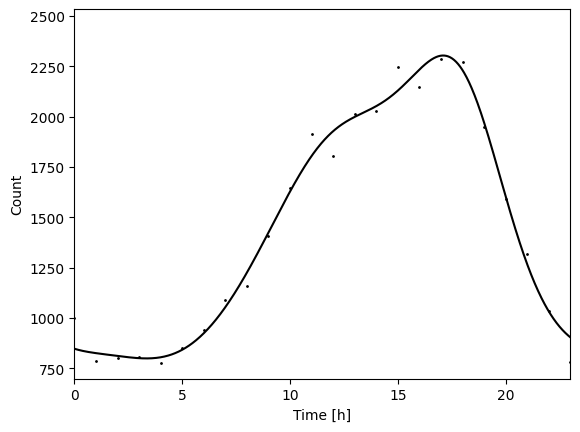

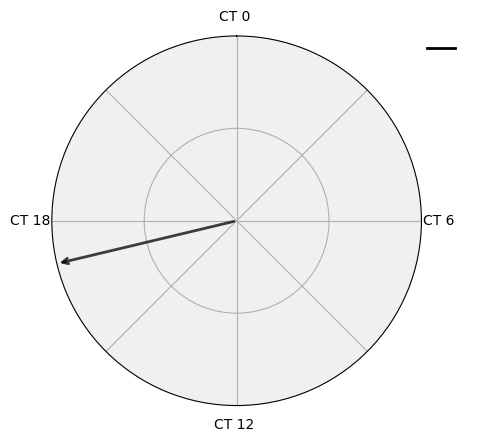

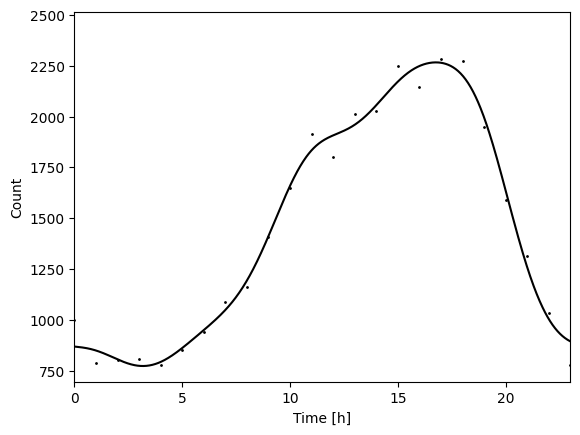

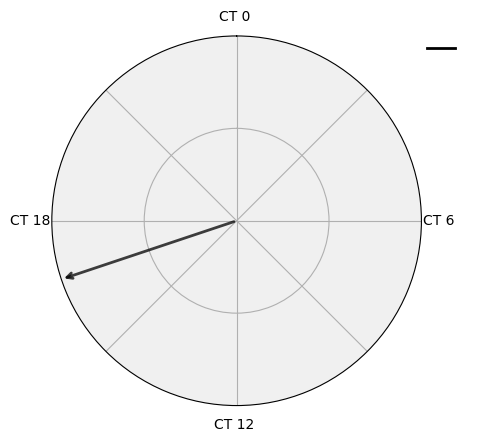

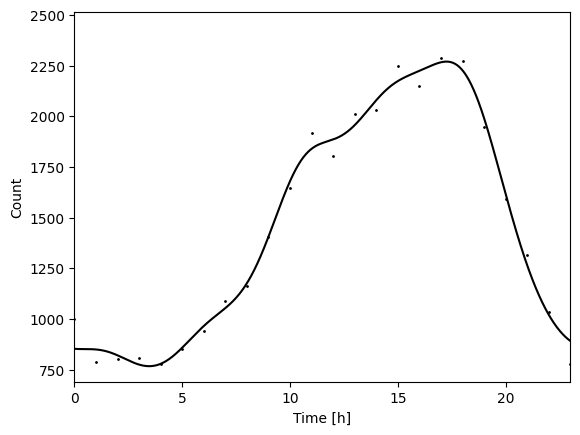

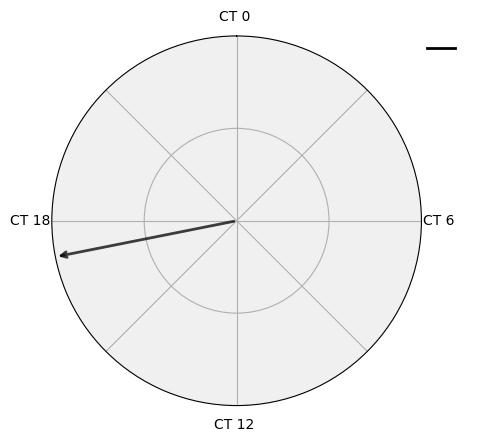

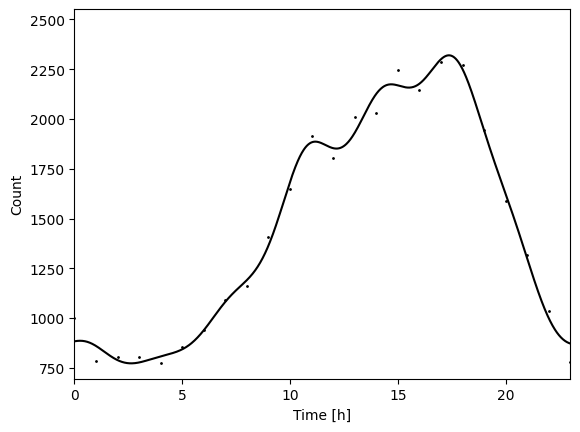

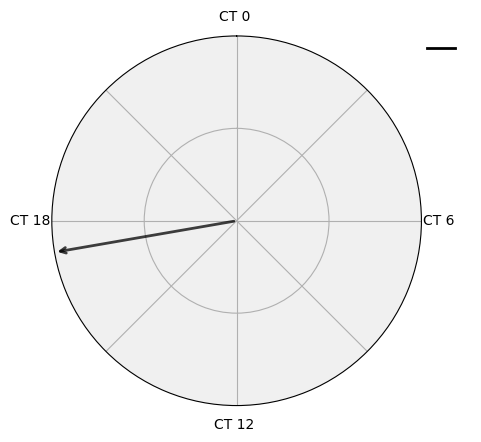

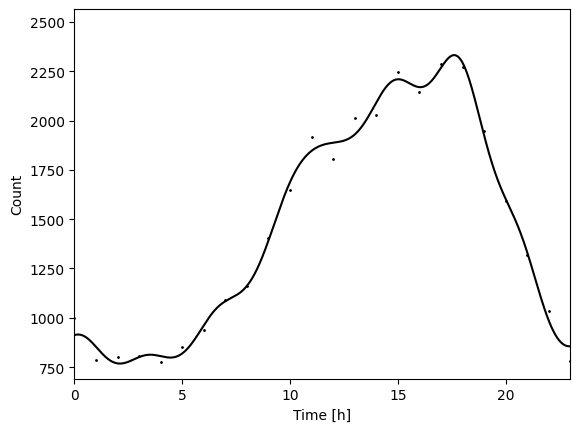

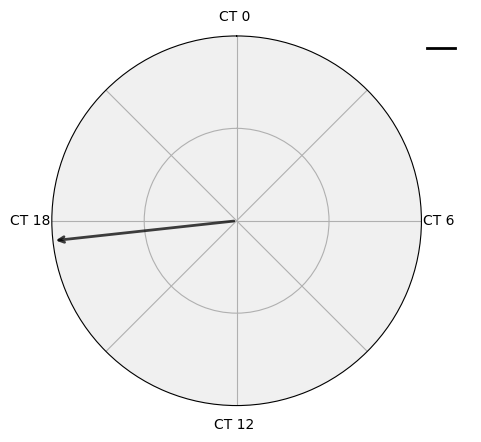

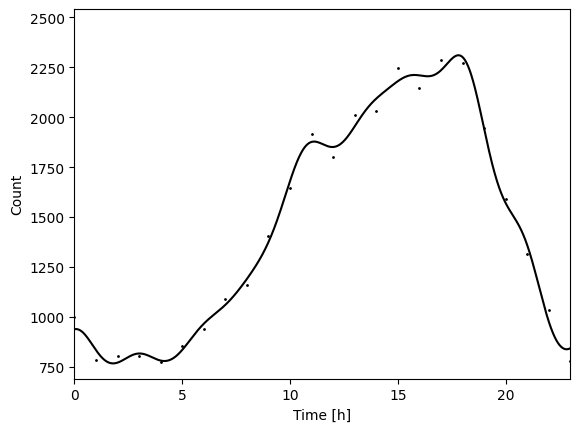

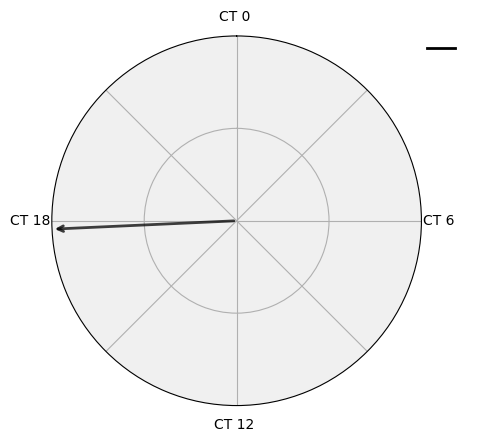

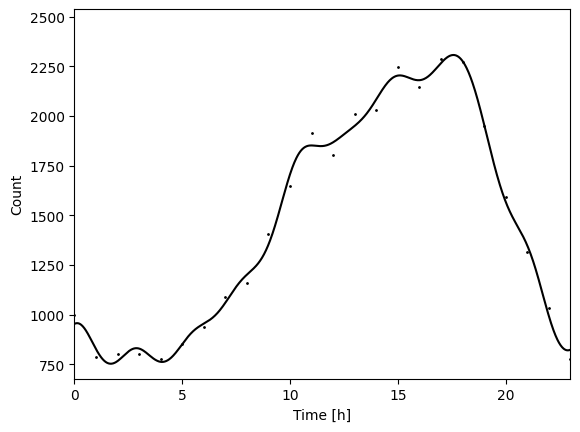

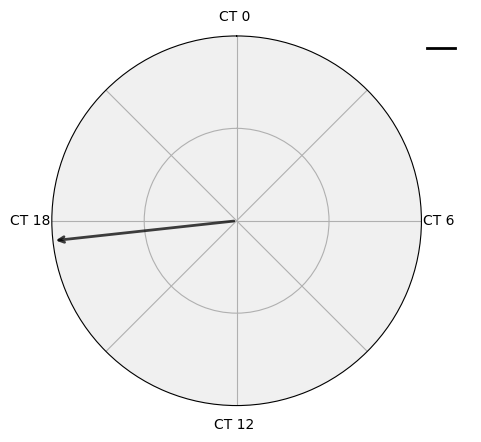

In [8]:
# VIKEND
X = df_weekends.x.to_numpy()
Y = df_weekends.y.to_numpy()

df_results_weekends = pd.DataFrame(columns=[
    'test', 'period', 'n_components', 'p', 'q', 'RSS', 
    'log-likelihood', 'prsquared', 'amplitude', 'acrophase', 
    'mesor', 'peaks', 'heights', 'troughs', 'heights2'
], dtype=float)

numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for i in numbers:
    results, statistics, rhythm_param, _, _ = cosinor.fit_me(X, Y, n_components = i, period = 24, model_type = 'gen_poisson', plot_margins=False)
    #result_table.append(result)

    # print("Statistics:", statistics.keys())
    # print("Rhythm parameters:", rhythm_param.keys())
    # print("Results attributes:", dir(results))

    df_results_weekends = df_add_row(df_results_weekends, {
        'test': 'HourlyAccidents_Weekends', 
        'period': 24,
        'n_components': i,
        'p': statistics['p'], 
        'RSS': statistics['RSS'],
        'log-likelihood': results.llf,        
        'prsquared': results.prsquared,  # Alternative to R²
        'amplitude': rhythm_param['amplitude'],
        'acrophase': rhythm_param['acrophase'],
        'mesor': rhythm_param['mesor'],
        'peaks': rhythm_param['peaks'],
        'heights': rhythm_param['heights'],
        'troughs': rhythm_param['troughs'],
        'heights2': rhythm_param['heights2']
    })

df_results_weekends.q = multi.multipletests(df_results_weekends.p, method = 'fdr_bh')[1]


In [9]:
df_results_weekends

,test,period,n_components,p,q,RSS,log-likelihood,prsquared,amplitude,acrophase,mesor,peaks,heights,troughs,heights2
0,HourlyAccidents_Weekends,24.0,1.0,3.362898e-16,3.362898e-16,401279.941626,-148.793643,0.193190,758.184100,2.358553,1543.531862,[14.99099099099099],[2301.704828662661],[2.978978978978979],[785.3477612614088]
1,HourlyAccidents_Weekends,24.0,2.0,6.349198e-17,9.070282e-17,220114.822680,-143.388102,0.222501,775.205392,2.119553,1512.504585,[15.903903903903904],[2287.6887820316933],[2.1621621621621623],[737.2991937698395]
2,HourlyAccidents_Weekends,24.0,3.0,7.165616e-19,7.165616e-18,105862.108622,-135.514785,0.265193,750.731100,1.855395,1557.429773,[16.912912912912912],[2308.123326245155],[1.5855855855855856],[806.6986723763397]
3,HourlyAccidents_Weekends,24.0,4.0,6.741756e-18,3.370878e-17,102947.148403,-134.907782,0.268484,752.012206,1.805079,1551.280035,[17.105105105105103],[2303.2922410350593],[3.3633633633633635],[799.2728333868566]
4,HourlyAccidents_Weekends,24.0,5.0,1.874867e-17,6.249555e-17,89537.773722,-133.265580,0.277389,746.685176,1.893132,1519.602974,[16.76876876876877],[2266.2881500938784],[3.171171171171171],[772.9177985160812]
5,HourlyAccidents_Weekends,24.0,6.0,1.159907e-16,1.288786e-16,79918.044761,-132.686474,0.280529,751.326225,1.767342,1518.128311,[17.24924924924925],[2269.4545357506545],[3.4594594594594597],[766.8020856100215]
6,HourlyAccidents_Weekends,24.0,7.0,7.777366e-17,9.721708e-17,63858.866477,-129.791199,0.296228,773.710864,1.742185,1546.205441,"[11.195195195195195, 14.702702702702702, 17.34...","[1886.1807293152435, 2174.1714189195086, 2319....","[2.6426426426426426, 23.255255255255253]","[772.4945766734949, 868.0554495694201]"
7,HourlyAccidents_Weekends,24.0,8.0,6.035221e-17,9.070282e-17,52130.384035,-127.137055,0.310620,781.826880,1.679290,1549.868351,"[15.03903903903904, 17.585585585585587]","[2209.260805611676, 2331.562679885193]","[2.114114114114114, 4.42042042042042, 22.96696...","[768.0414714190421, 798.417925681989, 855.5653..."
8,HourlyAccidents_Weekends,24.0,9.0,3.812805e-17,9.070282e-17,44780.219111,-124.311755,0.325939,771.463044,1.616395,1538.860760,"[11.0990990990991, 15.75975975975976, 17.82582...","[1878.1787617154541, 2211.6243905728397, 2310....","[1.7777777777777777, 4.18018018018018, 22.8228...","[767.4218986844969, 779.3353639037651, 838.162..."
9,HourlyAccidents_Weekends,24.0,10.0,4.638369e-17,9.070282e-17,38780.713102,-122.298902,0.336854,776.431897,1.679290,1530.175156,"[11.003003003003004, 15.087087087087086, 17.58...","[1851.6137468397026, 2203.87772540971, 2306.60...","[1.6816816816816818, 4.084084084084084, 22.870...","[753.7432589698426, 762.8056541736037, 821.115..."


## Najboljša modela

In [10]:
df_best_model_workdays = cosinor.get_best_models(df_workdays, df_results_work, n_components = [1,2,3,4,5,6,7,8,9,10])
df_best_model_workdays

,test,period,n_components,p,q,RSS,log-likelihood,prsquared,amplitude,acrophase,mesor,peaks,heights,troughs,heights2
0,HourlyAccidents_Workdays,24.0,6.0,2.053819e-26,5.134547e-26,258831.54392,-144.307393,0.345229,3219.307838,2.471764,3693.92845,"[6.63063063063063, 10.954954954954955, 14.5585...","[4437.729863084388, 4791.154853319141, 6913.23...",[2.4984984984984986],[474.62061130868506]


In [11]:
df_best_model_weekends = cosinor.get_best_models(df_weekends, df_results_weekends, n_components = [1,2,3,4,5,6,7,8,9,10])
df_best_model_weekends

,test,period,n_components,p,q,RSS,log-likelihood,prsquared,amplitude,acrophase,mesor,peaks,heights,troughs,heights2
0,HourlyAccidents_Weekends,24.0,3.0,7.165616e-19,7.165616e-18,105862.108622,-135.514785,0.265193,750.7311,1.855395,1557.429773,[16.912912912912912],[2308.123326245155],[1.5855855855855856],[806.6986723763397]


## RhythmCount

In [12]:
# Ustvari pandas dataframe v formatu, ki bo primeren za uporabo RhythmCount
df_workdays_RC = pd.DataFrame({
    "test": "HourlyAccidents_Workdays",  # konstantna oznaka vseh vrstic
    "X": accidents_per_hour_workdays.index,  # Ura (od 0 do 23)
    "Y": accidents_per_hour_workdays.values  # Število nesreč za tisto uro
})

df_weekends_RC = pd.DataFrame({
    "test": "HourlyAccidents_Weekends",  # konstantna oznaka vseh vrstic
    "X": accidents_per_hour_weekend.index,  # Ura (od 0 do 23)
    "Y": accidents_per_hour_weekend.values  # Število nesreč za tisto uro
})



In [13]:
count_models = ['gen_poisson', 'nb']
n_components = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

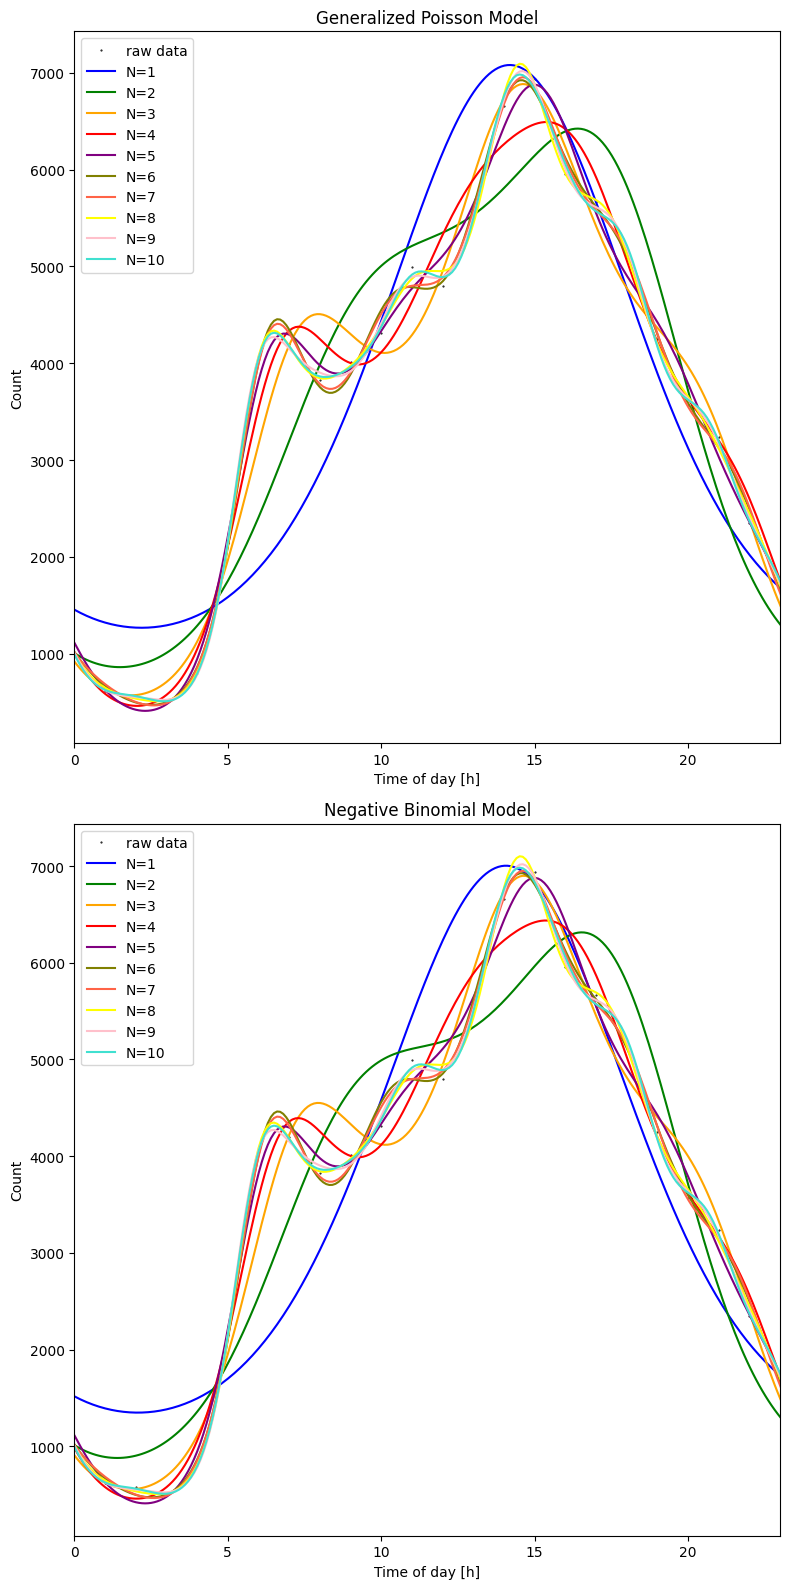

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

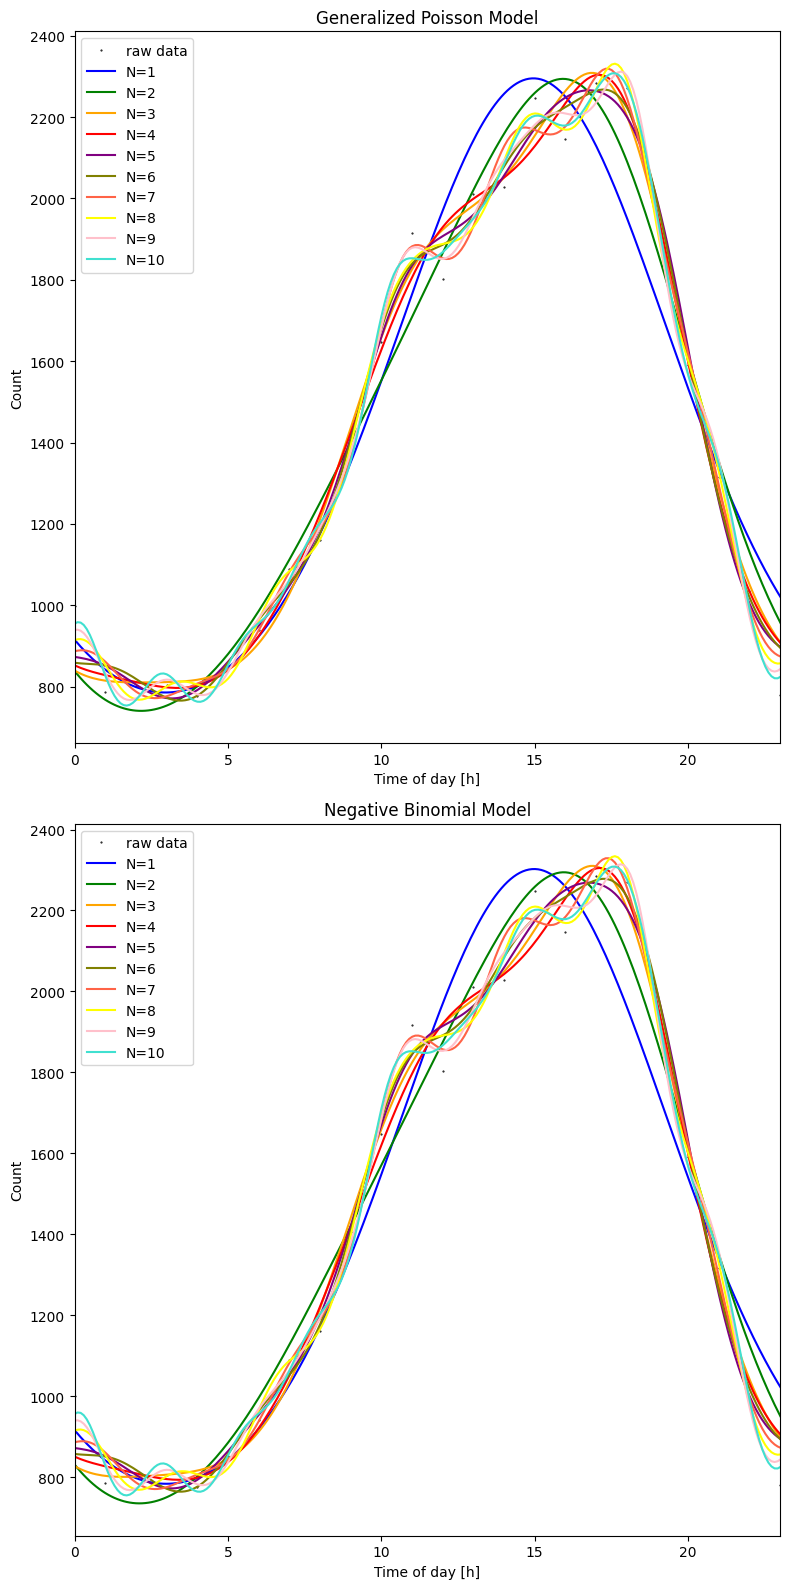

In [14]:
df_results_RC_work = dproc.fit_to_models(df_workdays_RC, count_models, n_components, 24)

df_results_RC_weekend = dproc.fit_to_models(df_weekends_RC, count_models, n_components, 24)

In [15]:
# display(df_results_RC_work)
# display(df_results_RC_weekend)

## Kateri model je najboljši?

#### Najprej pogledamo, kateri model je najboljši, nato kolikšno število komponent je najboljše.

In [16]:
# DELOVNIK
best_count_model_work = dproc.get_best_count_model(df_results_RC_work, 'Vuong')
print("Best model: {}".format(best_count_model_work.count_model))
best_model_work = dproc.get_best_n_components(df_results_RC_work, 'Vuong', count_model=best_count_model_work['count_model'])
print("Number of components: {}".format(best_model_work.n_components))

Best model: gen_poisson
Number of components: 6


In [17]:
# VIKEND
best_count_model_weekend = dproc.get_best_count_model(df_results_RC_weekend, 'Vuong')
print("Best model: {}".format(best_count_model_weekend.count_model))
best_model_weekend = dproc.get_best_n_components(df_results_RC_weekend, 'Vuong', count_model=best_count_model_weekend['count_model'])
print("Number of components: {}".format(best_model_weekend.n_components))

Best model: gen_poisson
Number of components: 3


#### Najprej pogledamo, kolikšno število komponent je najboljše, nato, kateri model je najboljši. 

In [18]:
# DELOVNIK
best_n_components_work = dproc.get_best_n_components(df_results_RC_work, 'Vuong')
print("Number of components: {}".format(best_n_components_work.n_components))
best_model_work = dproc.get_best_count_model(df_results_RC_work, 'Vuong', n_components=best_n_components_work['n_components'])
print("Best model: {}".format(best_model_work.count_model))

Number of components: 6
Best model: gen_poisson


In [19]:
# VIKEND
best_n_components_weekend = dproc.get_best_n_components(df_results_RC_weekend, 'Vuong')
print("Number of components: {}".format(best_n_components_weekend.n_components))
best_model_weekend = dproc.get_best_count_model(df_results_RC_weekend, 'Vuong', n_components=best_n_components_weekend['n_components'])
print("Best model: {}".format(best_model_weekend.count_model))

Number of components: 3
Best model: gen_poisson


### Prikaz najboljšega modela skupaj z intervali zaupanja (delovnik)

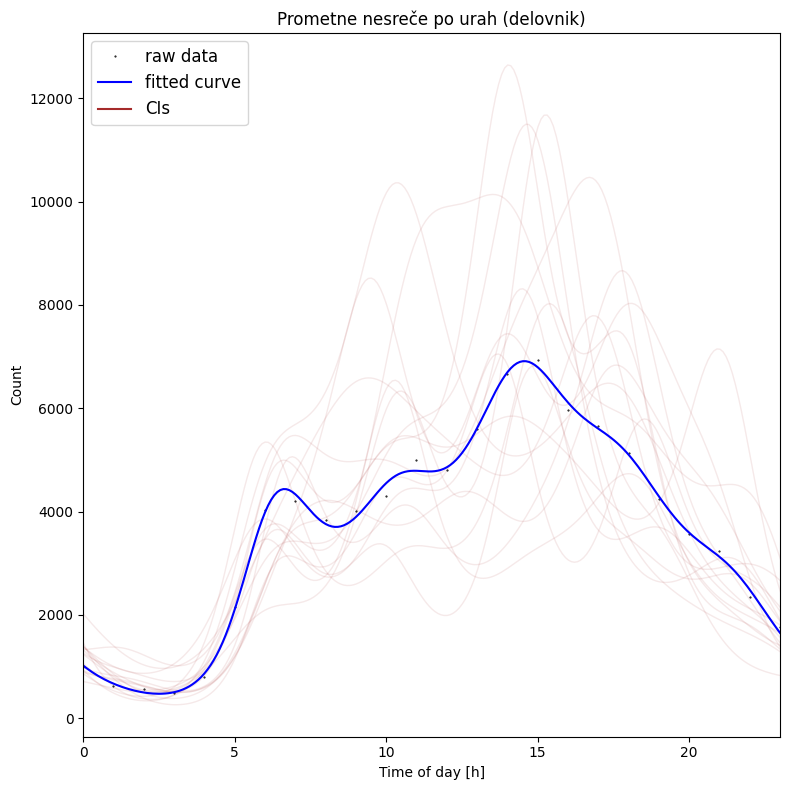

Intervali zaupanja:


,0,1
0,7.799419,8.165334
1,-0.650752,-0.293494
2,-1.149173,-0.530466
3,-0.546448,-0.029276
4,-0.463709,-0.054728
5,-0.514715,-0.031754
6,-0.043136,0.218537
7,-0.182101,0.104716
8,-0.038730,0.248832
9,-0.015128,0.146325


In [20]:
# DELOVNIK
count_model_work = best_model_work.count_model
n_components_work = int(best_n_components_work.n_components)

CIs_work = plot.plot_model(df_workdays_RC, count_model_work, n_components_work, title='Prometne nesreče po urah (delovnik)', plot_CIs=True)
print('Intervali zaupanja:')
display(CIs_work)

#### Parametri izbranega modela (delovnik)

In [21]:
CIs_params_work = dproc.calculate_confidence_intervals_parameters(df_workdays_RC, n_components_work, count_model_work, best_model_work['peaks'])
best_model_work = pd.concat([best_model_work, pd.Series(CIs_params_work)], axis=0)
best_model_work=best_model_work[['count_model','n_components','amplitude', 'mesor', 'peaks', 'heights','amplitude_CIs','mesor_CIs','peaks_CIs','heights_CIs']]
print('Parametri modela in njihovi intervali zaupanja:')
display(best_model_work.to_frame())

Parametri modela in njihovi intervali zaupanja:


,0
count_model,gen_poisson
n_components,6
amplitude,3226.77
mesor,3697.36
peaks,[14.61]
heights,[6924.13]
amplitude_CIs,"[2820.76, 3573.61]"
mesor_CIs,"[3270.91, 4089.9]"
peaks_CIs,"[13.83, 15.34]"
heights_CIs,"[6611.89, 7308.18]"


### Prikaz najboljšega modela skupaj z intervali zaupanja (vikend)

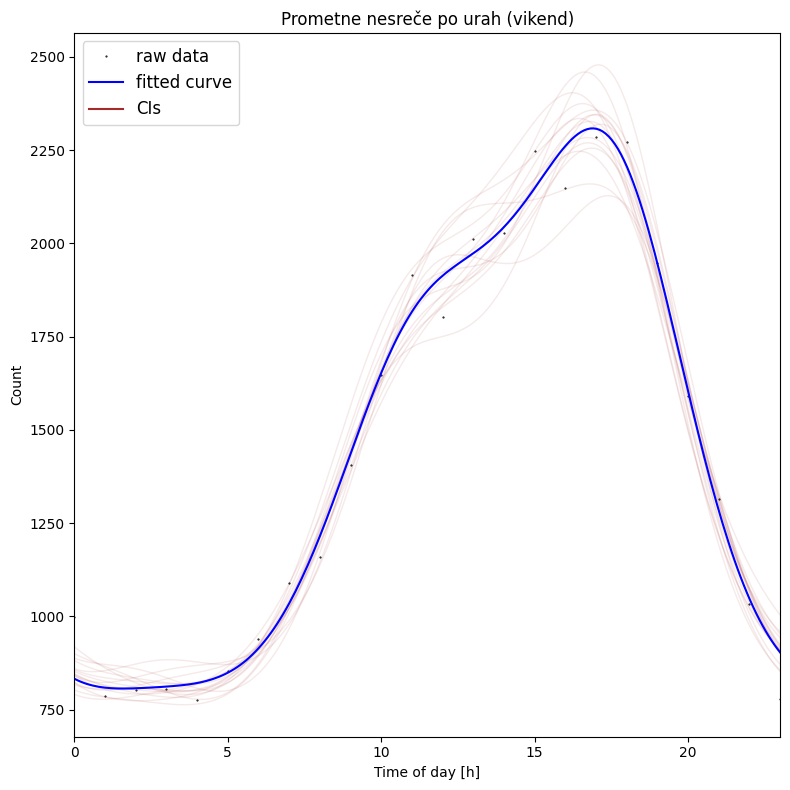

Intervali zaupanja:


,0,1
0,7.182567,7.222878
1,-0.397818,-0.345943
2,-0.442284,-0.356473
3,-0.032347,0.009894
4,-0.081090,-0.027402
5,0.044096,0.099014
6,-0.055365,0.024004
7,0.017831,1.464965


In [22]:
# VIKEND
count_model_weekend = best_model_weekend.count_model
n_components_weekend = int(best_n_components_weekend.n_components)

CIs_weekend = plot.plot_model(df_weekends_RC, count_model_weekend, n_components_weekend, title='Prometne nesreče po urah (vikend)', plot_CIs=True)
print('Intervali zaupanja:')
display(CIs_weekend)

#### Parametri izbranega modela (vikend)

In [23]:
CIs_params_weekend = dproc.calculate_confidence_intervals_parameters(df_weekends_RC, n_components_weekend, count_model_weekend, best_model_weekend['peaks'])
best_model_weekend = pd.concat([best_model_weekend, pd.Series(CIs_params_weekend)], axis=0)
best_model_weekend=best_model_weekend[['count_model','n_components','amplitude', 'mesor', 'peaks', 'heights','amplitude_CIs','mesor_CIs','peaks_CIs','heights_CIs']]
print('Parametri modela in njihovi intervali zaupanja:')
display(best_model_weekend.to_frame())

Parametri modela in njihovi intervali zaupanja:


,0
count_model,gen_poisson
n_components,3
amplitude,749.11
mesor,1559.49
peaks,[16.92]
heights,[2308.61]
amplitude_CIs,"[712.36, 819.74]"
mesor_CIs,"[1500.15, 1625.1]"
peaks_CIs,"[16.67, 17.13]"
heights_CIs,"[2241.6, 2415.74]"


### Na istem grafu

In [24]:
combined_df = pd.concat([df_workdays_RC, df_weekends_RC], axis=0, ignore_index=True)

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\discrete\discrete_model.py:3937: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\discrete\discrete_model.py:3938: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\discrete\discrete

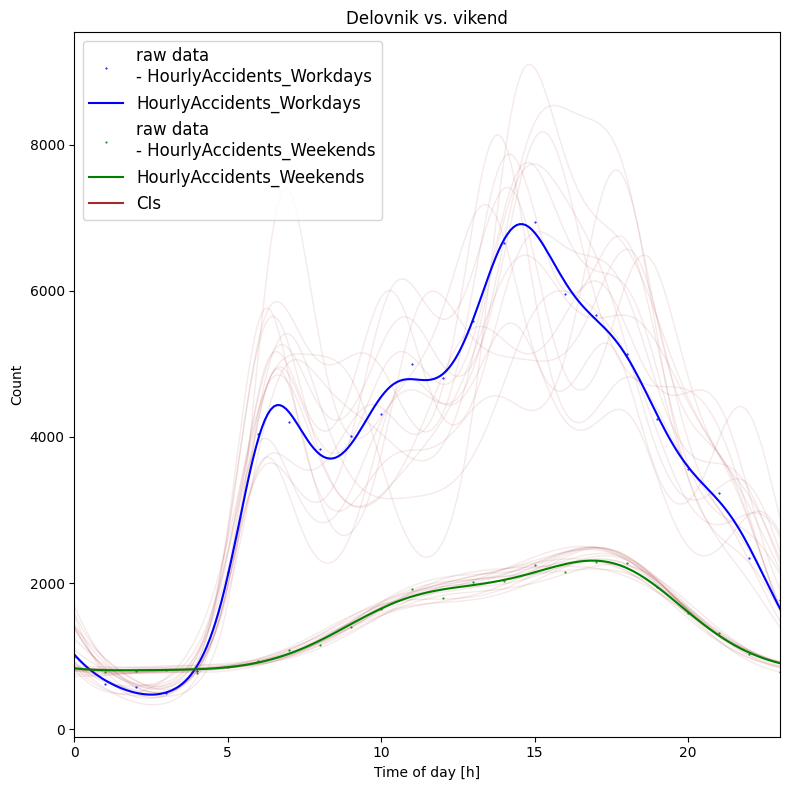

In [25]:
df_results_combined = dproc.compare_by_component(combined_df, 'test', n_components, count_models, ax_indices=[1, 1],
                           ax_titles=['Delovnik vs. vikend'], rows=1, cols=1)

In [26]:
display(df_results_combined)

,count_model,n_components,amplitude,mesor,peaks,heights,llr_pvalue,RSS,AIC,BIC,...,Y(est),X_test,Y_test,test,amplitude_CIs,mesor_CIs,peaks_CIs,heights_CIs,CIs_model_params_0,CIs_model_params_1
0,gen_poisson,6,3218.6,3693.21,[14.51],[6911.8],2.053822e-26,258832.302686,316.614789,333.107542,...,"[1021.5930613247091, 671.1399127332005, 499.34...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[1021.5930613247091, 975.6545674325915, 932.51...",HourlyAccidents_Workdays,"[3071.83, 3431.81]","[3581.35, 3916.66]","[14.11, 15.03]","[6658.01, 7343.64]","{0: 7.8561293557587994, 1: -0.536971542263135,...","{0: 8.064614510255723, 1: -0.44377395240972056..."
1,gen_poisson,3,750.7,1557.40,[16.92],[2308.1],7.165617e-19,105861.469622,287.029570,296.454000,...,"[832.952152277393, 809.0480158012647, 807.4034...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[832.952152277393, 828.8843116429031, 825.2592...",HourlyAccidents_Weekends,"[707.99, 803.46]","[1501.37, 1595.9]","[16.52, 17.29]","[2228.57, 2380.16]","{0: 7.172720580043005, 1: -0.3973675351463073,...","{0: 7.223836438870419, 1: -0.3459971036989302,..."
